In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import time
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import LabelEncoder
import xgboost

sns.set_theme(style="whitegrid")
sns.set_palette(palette="Paired")
SEED: int = 42

# Load Data
We load the already processed data from the `data/processed` directory.

In [2]:
X_train = pd.read_csv("../../data/processed/train_data_cleaned.csv", index_col="building_id")
y_train = pd.read_csv("../../data/processed/train_labels.csv", index_col="building_id", usecols=["building_id", "damage_grade"])

In [3]:
X_train.head(5)

,count_families,count_floors_pre_eq,geo_level_1_id,geo_level_2_id,geo_level_3_id,has_secondary_use,has_superstructure_cement_mortar_brick,has_superstructure_mud_mortar_stone,age,area_percentage,superstructure_quality,foundation_type_r,ground_floor_type_f,ground_floor_type_v,land_surface_condition_t,other_floor_type_q,position_s,roof_type_n
building_id,,,,,,,,,,,,,,,,,,
802906,0.111111,0.125,0.200000,0.341275,0.970637,0.0,0.0,1.0,0.121343,0.247589,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0
28830,0.111111,0.125,0.266667,0.630694,0.223761,0.0,0.0,1.0,0.040448,0.346625,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
94947,0.111111,0.125,0.700000,0.254380,0.714013,0.0,0.0,1.0,0.040448,0.198071,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
590882,0.111111,0.125,0.733333,0.292922,0.850959,0.0,0.0,1.0,0.040448,0.247589,0.5,1.0,1.0,0.0,1.0,0.0,1.0,1.0
201944,0.111111,0.250,0.366667,0.091801,0.118405,0.0,0.0,0.0,0.121343,0.346625,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0


In [4]:
y_train.head(5)

,damage_grade
building_id,
802906,3
28830,2
94947,3
590882,2
201944,3


## Create Validation Set

In [5]:
# Take subsample for PC to handle better
#X_train = X_train.iloc[:100000]
#y_train = y_train.iloc[:100000]

# Keep Hold Out Set for final prediction
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train, random_state=SEED, test_size=0.2)

# Drop Geo Level IDs ???
#X_train = X_train.drop(columns=["geo_level_1_id", "geo_level_2_id", "geo_level_3_id"], axis=1)
#X_test = X_test.drop(columns=["geo_level_1_id", "geo_level_2_id", "geo_level_3_id"], axis=1)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (208480, 18)
Shape of y_train: (208480, 1)
Shape of X_test: (52121, 18)
Shape of y_test: (52121, 1)


# Experimenting: Modelling different classifier
First we test some different classifier to see how they perform.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [7]:
def get_cross_validate_results(clf, cv=5):
    """
    Function to cross validate a given classifier.
    :param clf: Classifier, e.g. RandomForest Object
    :param cv: Number of k-folds
    :return: cv_results -- Dictionary of the cross validation results
    """
    start_time = time.time()

    # Label encode y_train for Xgboost (expects 0, 1, 2, not 1, 2, 3)
    if isinstance(clf, xgboost.XGBClassifier):
        encoder = LabelEncoder()
        y_train_encoded = encoder.fit_transform(y_train["damage_grade"].to_numpy())
        cv_results = cross_validate(clf,
                                    X_train,
                                    y_train_encoded,
                                    cv=cv,
                                    scoring=["matthews_corrcoef", "accuracy"],
                                    n_jobs=-1,
                                    return_train_score=True)
    else:
        cv_results = cross_validate(clf,
                                    X_train,
                                    y_train["damage_grade"].ravel(),
                                    cv=cv,
                                    scoring=["matthews_corrcoef", "accuracy"],
                                    n_jobs=-1,
                                    return_train_score=True)
    end_time = time.time()
    print(f"Time elapsed for CV: {(end_time - start_time):.2f}s of {str(clf)}")
    return cv_results

# Define Classifiers here
dt = DecisionTreeClassifier(random_state=SEED)
rf = RandomForestClassifier(random_state=SEED)
logit = LogisticRegression(penalty="l2", verbose=True, solver="saga", random_state=SEED)
mlp = MLPClassifier(random_state=SEED)
knn = KNeighborsClassifier()
svc = SVC(random_state=42)
xgb = xgboost.XGBClassifier(random_state=42, n_jobs=-1)

# Get CV Results
cv_results_xgboost = get_cross_validate_results(xgb)
cv_results_dt = get_cross_validate_results(dt)
cv_results_rf = get_cross_validate_results(rf)
cv_results_logit = get_cross_validate_results(logit)
cv_results_mlp = get_cross_validate_results(mlp)
#cv_results_knn = get_cross_validate_results(knn)
#cv_results_svc = get_cross_validate_results(svc)

Time elapsed for CV: 194.36s of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)
Time elapsed for CV: 3.25s of DecisionTreeClassifier(random_state=42)
Time elapsed for CV: 88.90s of RandomForestClassifier(random_state=42)
Time elapsed for CV: 7.75s of LogisticRegression(random_state=42, solver='saga'

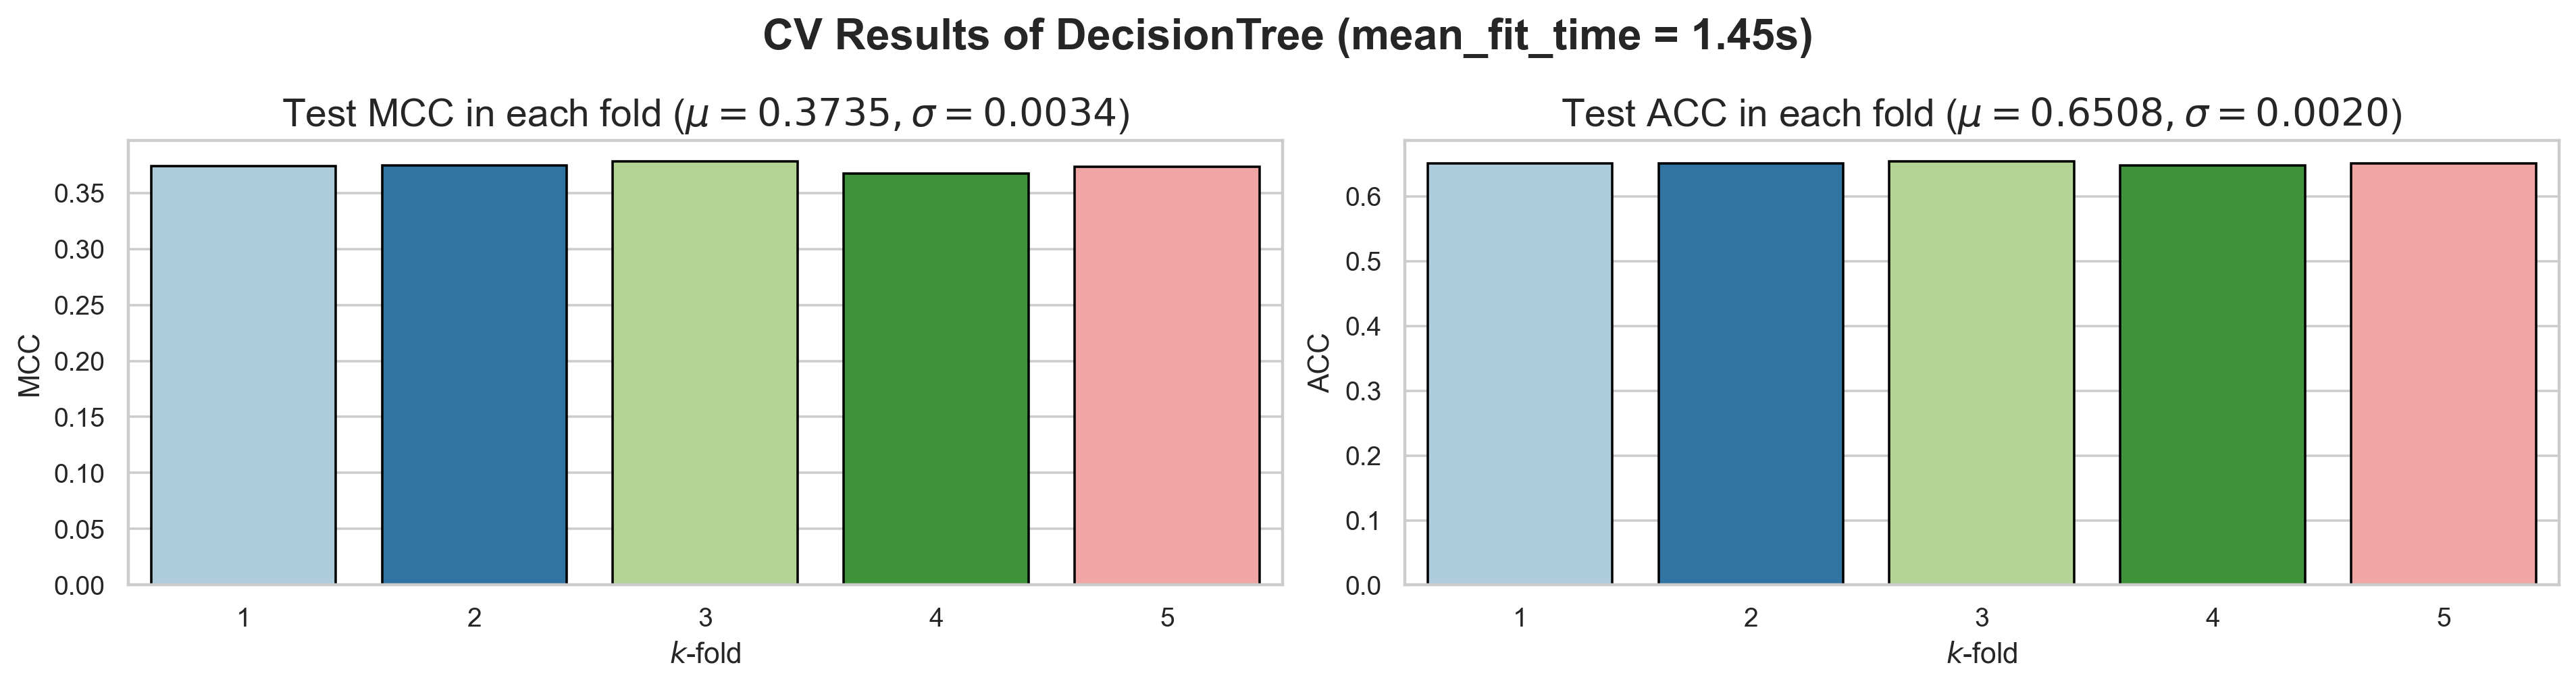

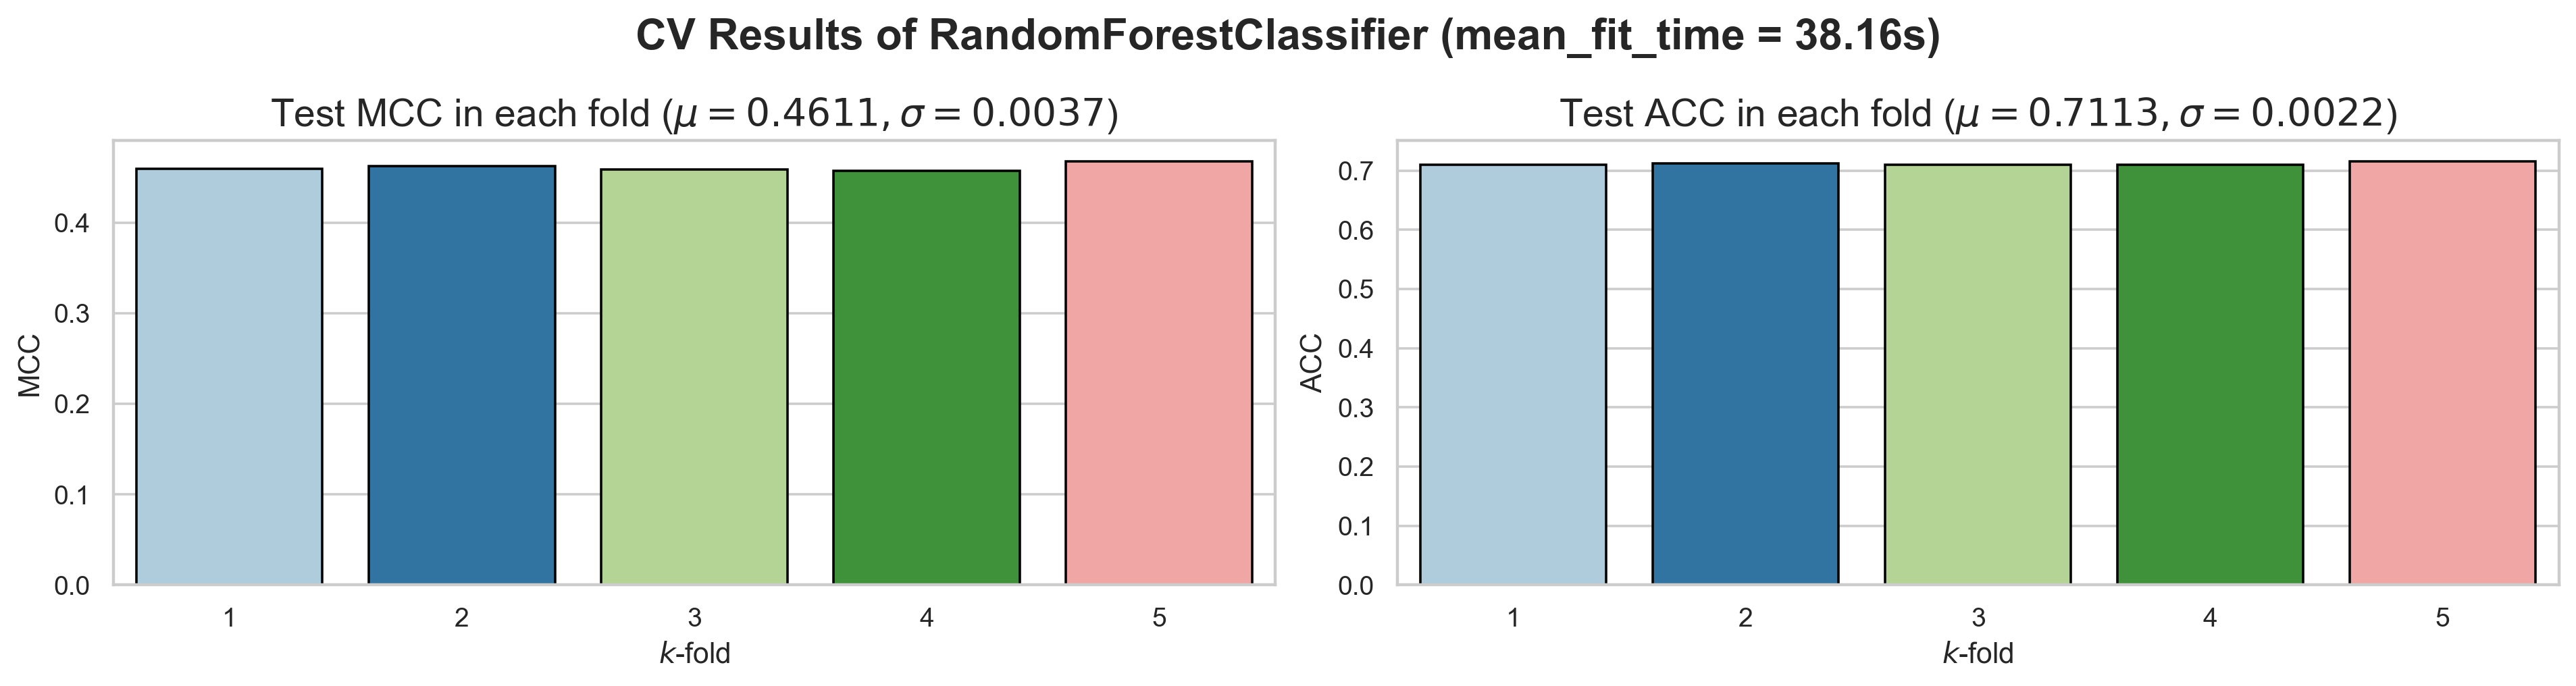

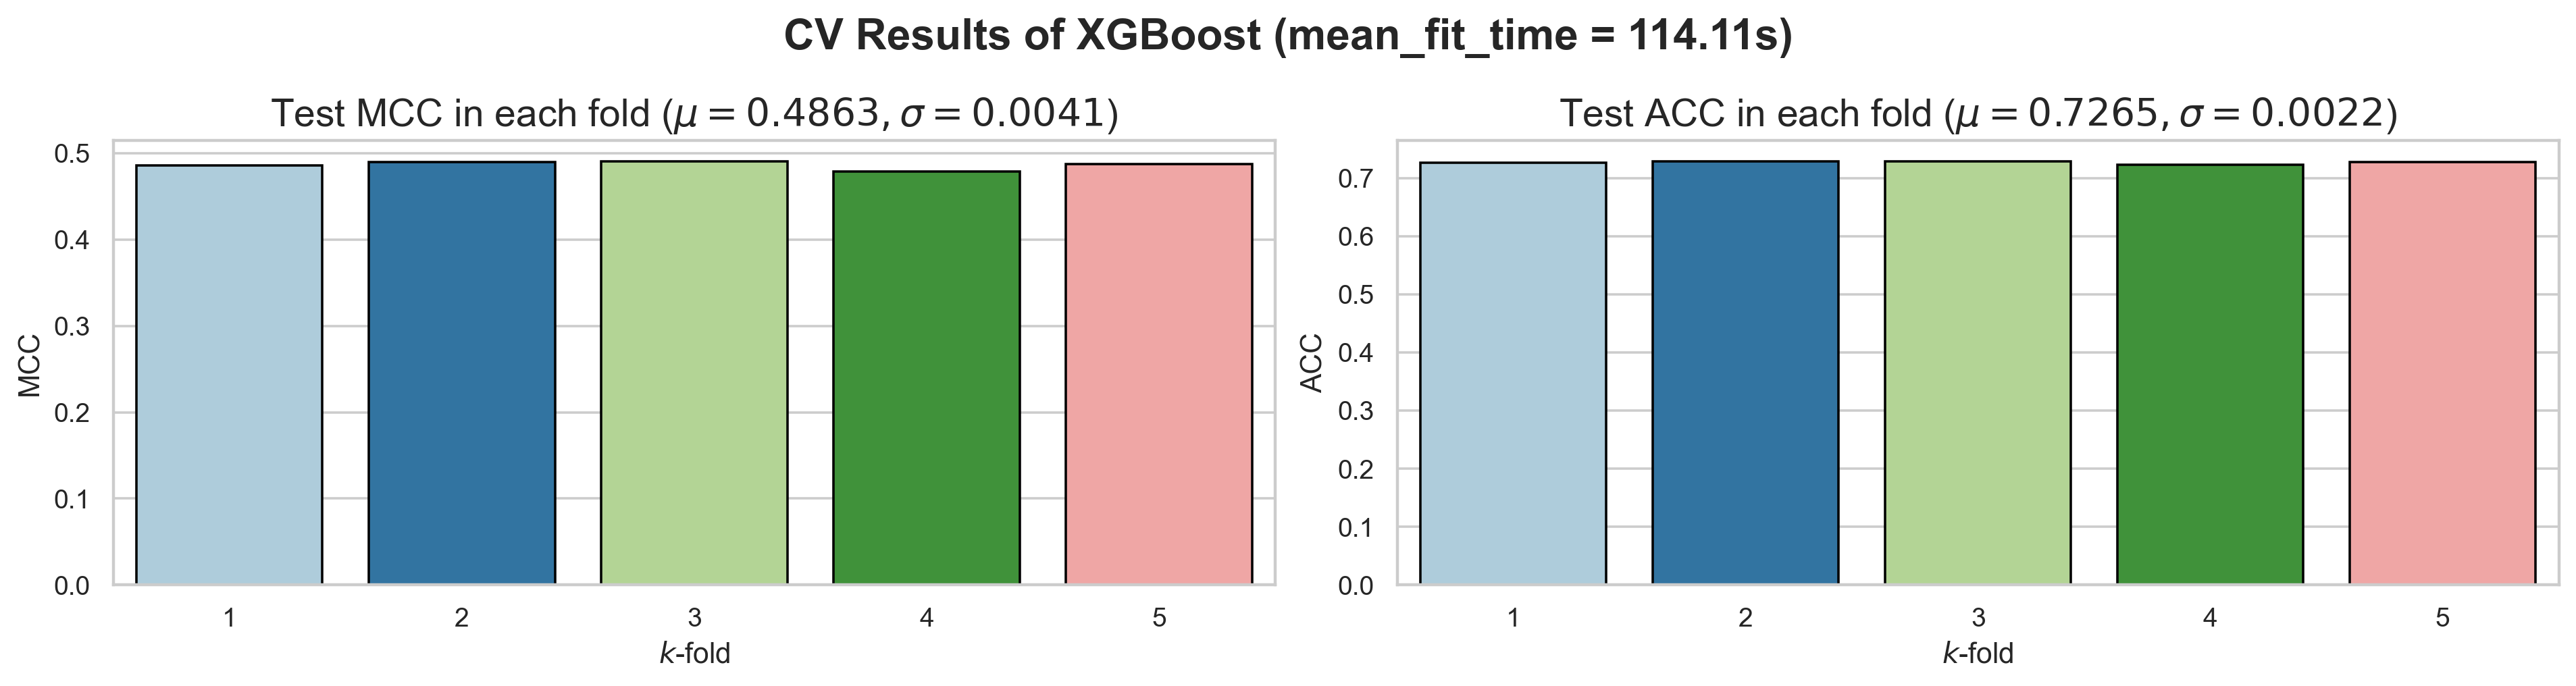

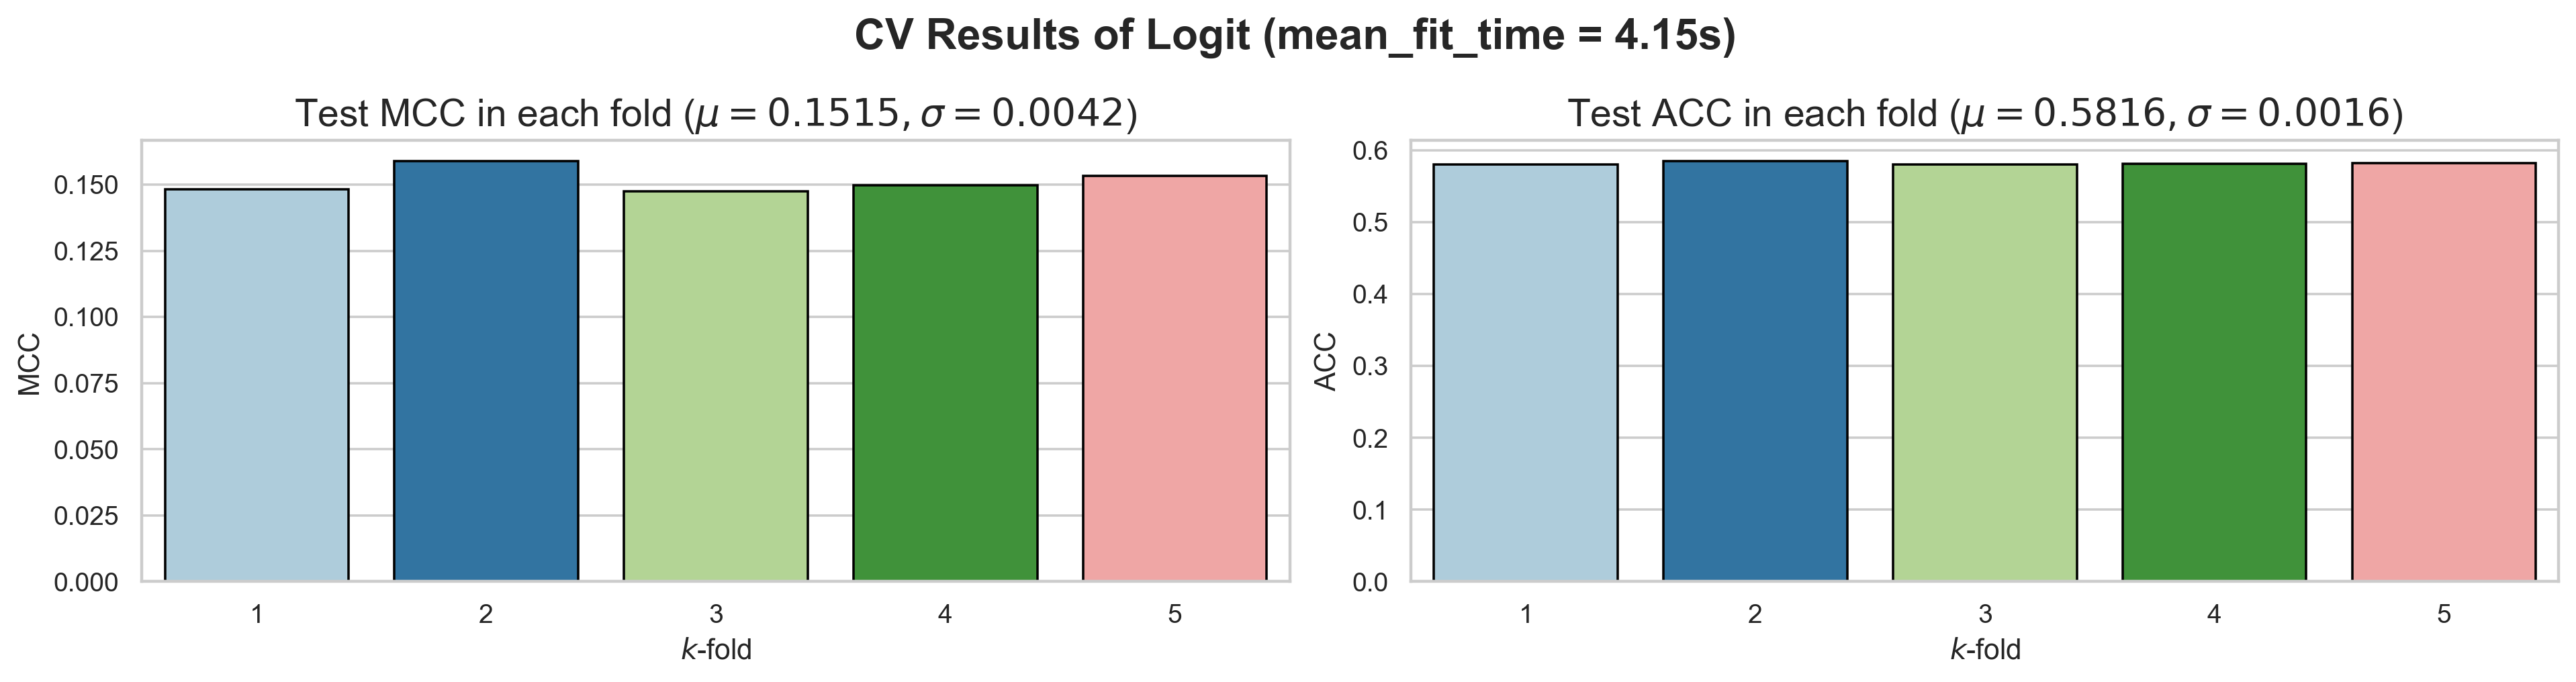

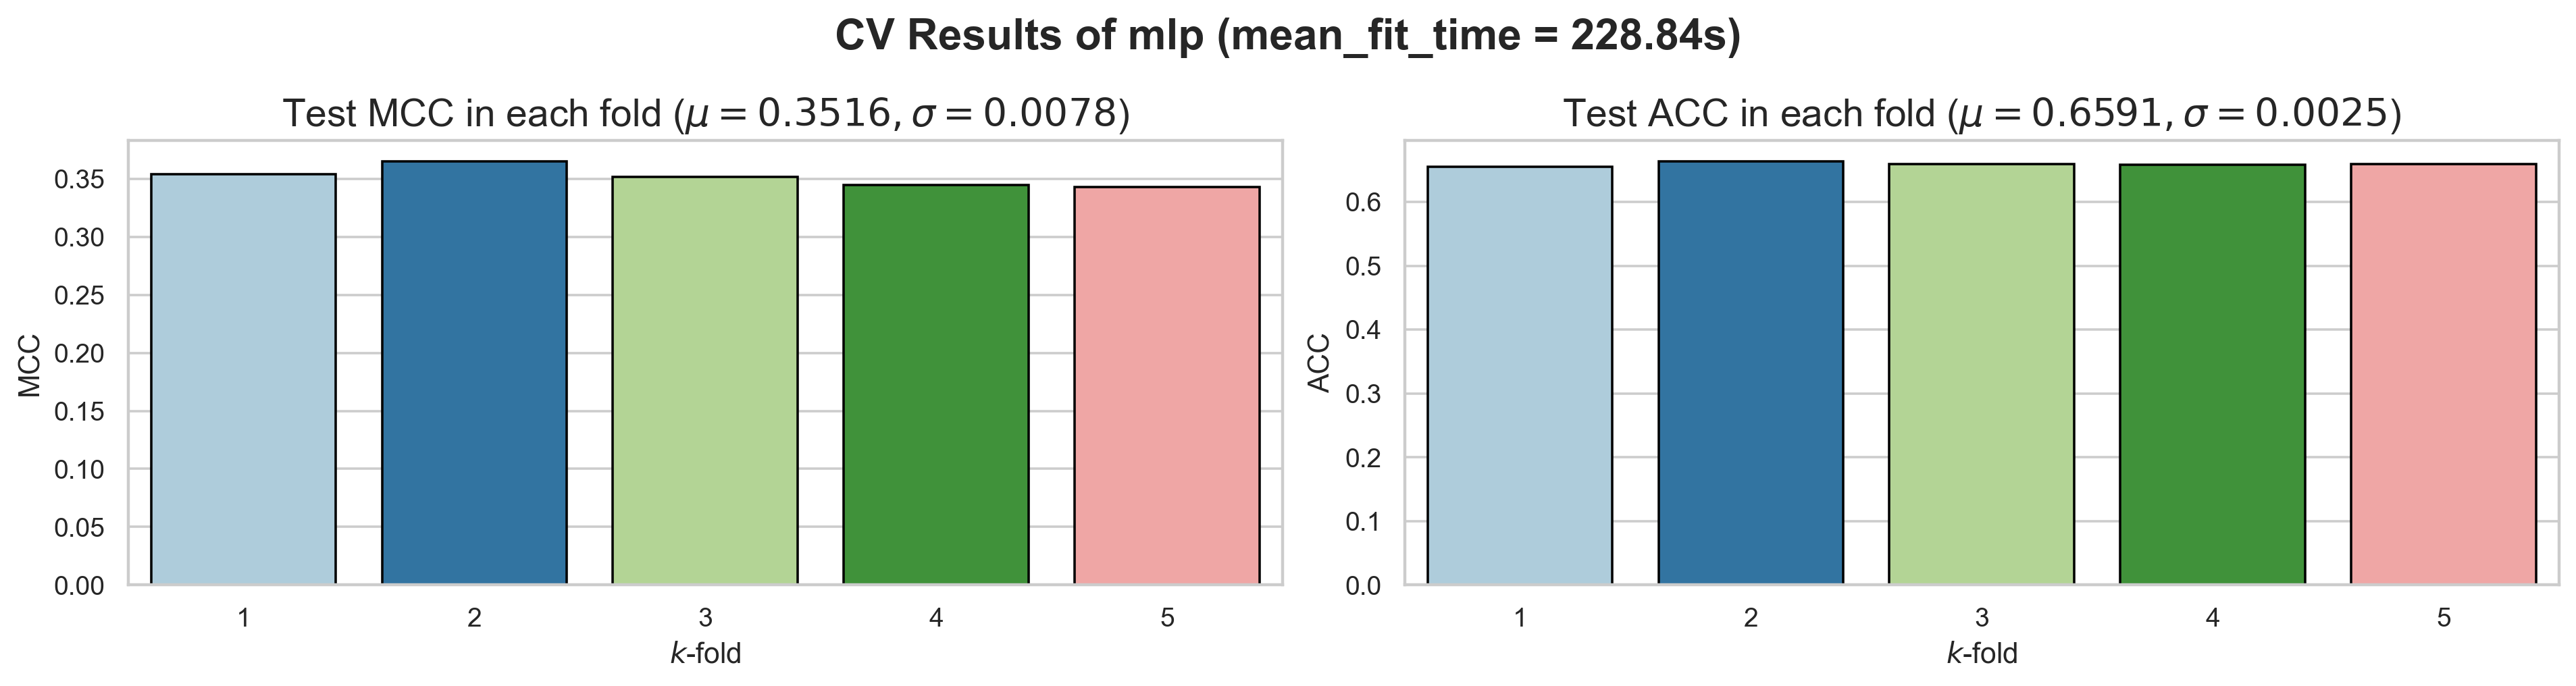

In [8]:
def plot_cv_results(cv_results:dict, classifier:str):
    """
    Plots the cv_results dictionary for a better comparsion.
    :param cv_results:
    :param classifier:
    :return:
    """
    k_folds = len(cv_results.get("test_matthews_corrcoef"))

    # Get mean of mcc, acc and fit time and std
    mean_fit_time = np.mean(cv_results.get("fit_time"))
    mean_mcc = np.mean(cv_results.get("test_matthews_corrcoef"))
    std_mcc = np.std(cv_results.get("test_matthews_corrcoef"))
    mean_acc = np.mean(cv_results.get("test_accuracy"))
    std_acc = np.std(cv_results.get("test_accuracy"))

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4), dpi=256)
    fig.suptitle(f"CV Results of {classifier} (mean_fit_time = {mean_fit_time:.2f}s)", size=18, fontweight='bold')
    sns.barplot(x=np.arange(1, k_folds+1),
                y=cv_results.get("test_matthews_corrcoef"),
                ax=axes[0], edgecolor="black")
    axes[0].set_title(f"Test MCC in each fold ($\mu = {mean_mcc:.4f}, \sigma = {std_mcc:.4f}$)", size=16)
    axes[0].set_xlabel("$k$-fold")
    axes[0].set_ylabel("MCC")

    sns.barplot(x=np.arange(1, k_folds+1),
                y=cv_results.get("test_accuracy"),
                ax=axes[1], edgecolor="black")
    axes[1].set_title(f"Test ACC in each fold ($\mu = {mean_acc:.4f}, \sigma = {std_acc:.4f}$)", size=16)
    axes[1].set_xlabel("$k$-fold")
    axes[1].set_ylabel("ACC")
    plt.tight_layout()
    plt.show()

plot_cv_results(cv_results_dt, classifier="DecisionTree")
plot_cv_results(cv_results_rf, classifier="RandomForestClassifier")
plot_cv_results(cv_results_xgboost, classifier="XGBoost")
plot_cv_results(cv_results_logit, classifier="Logit")
plot_cv_results(cv_results_mlp, classifier="mlp")
#plot_cv_results(cv_results_knn, classifier="KNN")
#plot_cv_results(cv_results_svc, classifier="SVC rbf")

_______
# Take a deeper look: Multinomial Logistic Regression
In this week subtasks we dive deeper into some models and try to get some Explainability and Interpretability out of them.

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import classification_report

In [10]:
# Get best logit model using CV
logit = LogisticRegressionCV(scoring="accuracy",
                             random_state=42,
                             max_iter=1000,
                             multi_class="multinomial").fit(X_train, y_train.damage_grade.ravel())

In [11]:
# Get Logit Coefficients for better understanding
logit_coefficients = pd.DataFrame(logit.coef_, columns=X_train.columns)
logit_coefficients

,count_families,count_floors_pre_eq,geo_level_1_id,geo_level_2_id,geo_level_3_id,has_secondary_use,has_superstructure_cement_mortar_brick,has_superstructure_mud_mortar_stone,age,area_percentage,superstructure_quality,foundation_type_r,ground_floor_type_f,ground_floor_type_v,land_surface_condition_t,other_floor_type_q,position_s,roof_type_n
0,-2.238889,-1.417327,0.406819,0.126226,0.013686,0.114434,0.636351,-0.379094,-2.275737,0.171191,0.984754,-0.524854,-0.125174,0.711036,0.147452,-0.159878,0.268693,0.128127
1,0.545924,-0.062331,-0.483041,-0.100773,-0.050269,0.075345,0.294466,0.062245,1.263735,0.120863,-0.125977,-0.051656,0.040883,0.116323,-0.118882,0.263670,-0.020020,0.040897
2,1.692965,1.479658,0.076222,-0.025452,0.036583,-0.189779,-0.930817,0.316849,1.012002,-0.292054,-0.858776,0.576509,0.084291,-0.827359,-0.028571,-0.103791,-0.248673,-0.169024


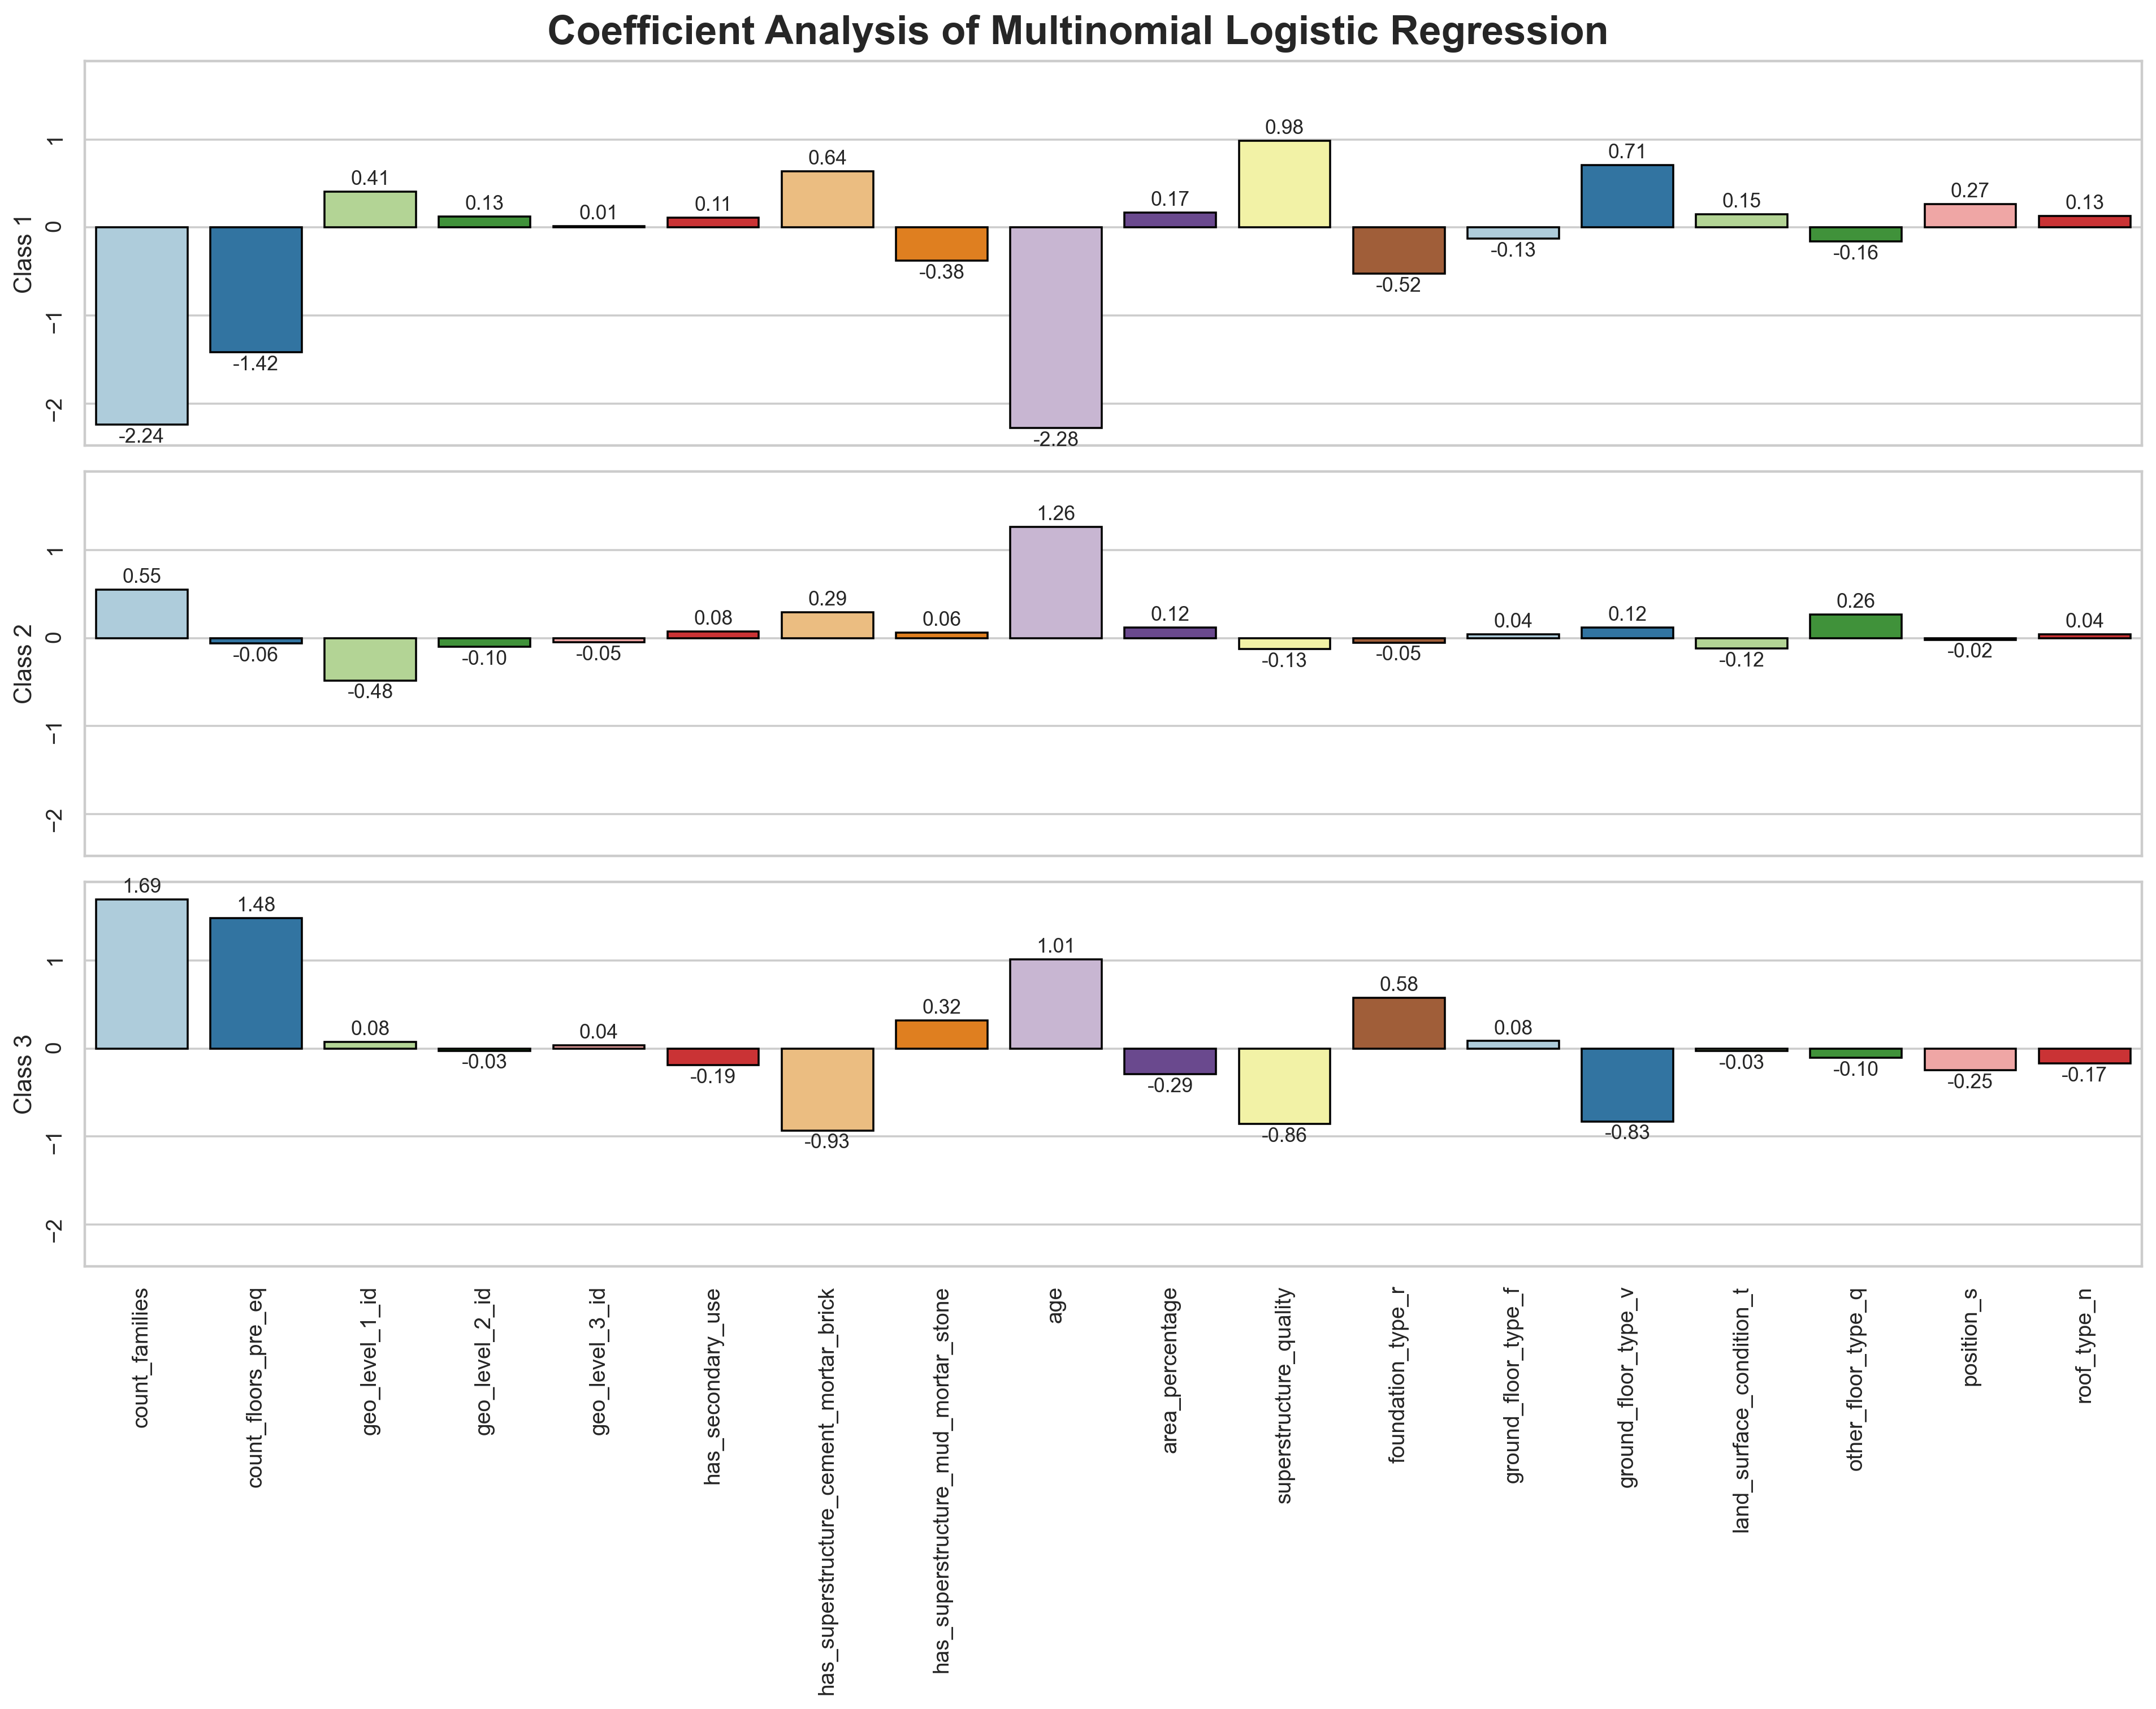

In [12]:
# Plot coefficients
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 12), dpi=256, sharex=True, sharey=True)
fig.suptitle("Coefficient Analysis of Multinomial Logistic Regression", fontweight="bold", size=20)
for i, ax in enumerate(axes.flatten()):
    g = sns.barplot(x=logit_coefficients.columns, y=logit_coefficients.iloc[i, :], ax=ax, edgecolor="black", palette="Paired")
    g.bar_label(g.containers[0], padding=1.5, fmt="%.2f")
    ax.tick_params(labelrotation=90)
    ax.set_ylabel(f"Class {i+1}")
plt.tight_layout()
plt.show()

In [13]:
predictions = pd.DataFrame(logit.predict_proba(X_test), columns=[f"P(y={i}|x)" for i in list(logit.classes_)])
predictions["y_pred"] = logit.predict(X_test)
predictions.head(5)

,P(y=1|x),P(y=2|x),P(y=3|x),y_pred
0,0.006482,0.536472,0.457046,2
1,0.168861,0.629272,0.201867,2
2,0.101826,0.498804,0.399370,2
3,0.118919,0.535987,0.345094,2
4,0.072520,0.616327,0.311153,2


Matthews Correlation Coefficient (MCC): 0.1539
______________________________________________________________________
              precision    recall  f1-score   support

           1       0.54      0.26      0.36      5025
           2       0.59      0.89      0.71     29652
           3       0.53      0.15      0.23     17444

    accuracy                           0.58     52121
   macro avg       0.56      0.43      0.43     52121
weighted avg       0.57      0.58      0.52     52121



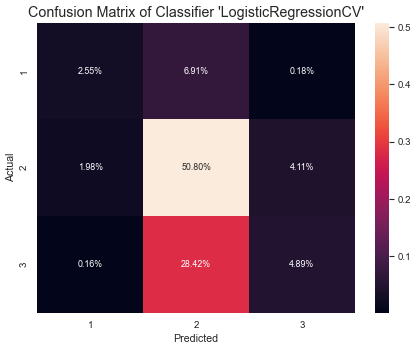

In [14]:
def plot_evaluation(clf, X_test, y_test, show_percentage = False):
    """
    Function to plot and print evaluation of an classifier on the hold out set
    :param clf: Fitted classifier
    :param X_test: Hold out test set
    :param y_test: Labels of the test set
    :param show_percentage: Boolean -- Whether to print percentages in confusion matrix or not
    :return: None
    """
    y_pred = clf.predict(X_test)

    # Compute and print MCC
    mcc = matthews_corrcoef(y_true=y_test, y_pred=y_pred)
    print(f"Matthews Correlation Coefficient (MCC): {mcc :.4f}")
    print(70 * "_")

    # Plot Confusion Matrix as a table (with precision, recall, f1, ...)
    print(classification_report(y_true = y_test, y_pred = y_pred))

    # Plot settings
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
    plt.figure(figsize=(8, 6), dpi=64)
    plt.title(f"Confusion Matrix of Classifier '{str(clf).split('(')[0]}'", size=16)
    if show_percentage:
        ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt=".2%", xticklabels=[1,2,3], yticklabels=[1,2,3])
    else:
        ax = sns.heatmap(cm, annot=True, fmt=".0f", xticklabels=[1,2,3], yticklabels=[1,2,3])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    plt.show()

plot_evaluation(clf=logit, X_test=X_test, y_test=y_test, show_percentage=True)

__________
# Take a deeper look: Ordered Logit Model
We can also apply an ordered logit model using the library `statsmodels`.
[Recommended Reading](https://analyticsindiamag.com/a-complete-tutorial-on-ordinal-regression-in-python/).

In [15]:
from statsmodels.miscmodels.ordinal_model import OrderedModel

ordered_logit = OrderedModel(endog=y_train.damage_grade.ravel(),
                             exog=X_train,
                             distr='logit')
res_ordered_logit = ordered_logit.fit(method="bfgs")

convergence after 22 epochs took 4 seconds
convergence after 22 epochs took 3 seconds
Epoch 1, change: 1.00000000
Epoch 2, change: 0.17117793
Epoch 3, change: 0.11329934
Epoch 4, change: 0.05361555
Epoch 5, change: 0.05290141
Epoch 6, change: 0.03828768
Epoch 7, change: 0.02194611
Epoch 8, change: 0.01567873
Epoch 9, change: 0.01202449
Epoch 10, change: 0.00463116
Epoch 11, change: 0.00959317
Epoch 12, change: 0.00758841
Epoch 13, change: 0.00309372
Epoch 14, change: 0.00203265
Epoch 15, change: 0.00100287
Epoch 16, change: 0.00078126
Epoch 17, change: 0.00043033
Epoch 18, change: 0.00034032
Epoch 19, change: 0.00019742
Epoch 20, change: 0.00021907
Epoch 21, change: 0.00015414
Epoch 1, change: 1.00000000
Epoch 2, change: 0.17758862
Epoch 3, change: 0.12400422
Epoch 4, change: 0.08074970
Epoch 5, change: 0.05369153
Epoch 6, change: 0.04936885
Epoch 7, change: 0.03577081
Epoch 8, change: 0.01617990
Epoch 9, change: 0.00929647
Epoch 10, change: 0.01151215
Epoch 11, change: 0.00712462
Epoc

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s finished
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


convergence after 23 epochs took 4 seconds
Epoch 1, change: 1.00000000
Epoch 2, change: 0.17048488
Epoch 3, change: 0.27198179
Epoch 4, change: 0.11070463
Epoch 5, change: 0.05936248
Epoch 6, change: 0.04027258
Epoch 7, change: 0.02815429
Epoch 8, change: 0.02014477
Epoch 9, change: 0.01130673
Epoch 10, change: 0.00761482
Epoch 11, change: 0.00481364
Epoch 12, change: 0.00344528
Epoch 13, change: 0.00471688
Epoch 14, change: 0.00364124
Epoch 15, change: 0.00122341
Epoch 16, change: 0.00133710
Epoch 17, change: 0.00104551
Epoch 18, change: 0.00030928
Epoch 19, change: 0.00026921
Epoch 20, change: 0.00019791
Epoch 21, change: 0.00014101
Epoch 22, change: 0.00010075


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s finished
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


convergence after 23 epochs took 4 seconds
Epoch 1, change: 1.00000000
Epoch 2, change: 0.17395853
Epoch 3, change: 0.15709265
Epoch 4, change: 0.05902388
Epoch 5, change: 0.06804266
Epoch 6, change: 0.03533018
Epoch 7, change: 0.02528132
Epoch 8, change: 0.02144309
Epoch 9, change: 0.01303994
Epoch 10, change: 0.00695612
Epoch 11, change: 0.00764769
Epoch 12, change: 0.00794764
Epoch 13, change: 0.00316073
Epoch 14, change: 0.00153897
Epoch 15, change: 0.00108476
Epoch 16, change: 0.00079160
Epoch 17, change: 0.00072809
Epoch 18, change: 0.00031153
Epoch 19, change: 0.00030552
Epoch 20, change: 0.00023483
Epoch 21, change: 0.00015564
Epoch 22, change: 0.00013460


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s finished
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Optimization terminated successfully.
         Current function value: 0.814626
         Iterations: 130
         Function evaluations: 131
         Gradient evaluations: 131


In [16]:
res_ordered_logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                      y   Log-Likelihood:            -1.6983e+05
Model:                   OrderedModel   AIC:                         3.397e+05
Method:            Maximum Likelihood   BIC:                         3.399e+05
Date:                Sat, 13 May 2023                                         
Time:                        13:29:40                                         
No. Observations:              208480                                         
Df Residuals:                  208460                                         
Df Model:                          20                                         
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
count_families                             1.8128      0.097     18.743      0.000       1.623       2.002
count_floors_pre_eq                        1.8080      0.056     32.053      0.000       1.697       1.919
geo_level_1_id                             0.2140      0.017     12.549      0.000       0.181       0.247
geo_level_2_id                            -0.0077      0.015     -0.498      0.618      -0.038       0.023
geo_level_3_id                             0.0451      0.015      2.963      0.003       0.015       0.075
has_secondary_use                         -0.2099      0.014    -14.608      0.000      -0.238      -0.182
has_superstructure_cement_mortar_brick    -0.7694      0.023    -33.095      0.000      -0.815      -0.724
has_superstructure_mud_mortar_stone        0.5122      0.015     35.281      0.000       0.484       0.541
age                                        0.3755      0.045      8.314      0.000       0.287       0.464
area_percentage                           -0.3051      0.026    -11.675      0.000      -0.356      -0.254
superstructure_quality                    -1.1125      0.019    -60.065      0.000      -1.149      -1.076
foundation_type_r                          0.8215      0.018     45.635      0.000       0.786       0.857
ground_floor_type_f                        0.0870      0.015      5.796      0.000       0.058       0.116
ground_floor_type_v                       -0.9740      0.024    -39.788      0.000      -1.022      -0.926
land_surface_condition_t                   0.0015      0.012      0.125      0.901      -0.022       0.025
other_floor_type_q                        -0.2032      0.011    -18.666      0.000      -0.224      -0.182
position_s                                -0.2852      0.011    -25.556      0.000      -0.307      -0.263
roof_type_n                               -0.1907      0.010    -18.596      0.000      -0.211      -0.171
1/2                                       -1.8904      0.034    -55.206      0.000      -1.958      -1.823
2/3                                        1.2662      0.003    425.632      0.000       1.260       1.272
==========================================================================================================
"""

In [17]:
y_pred_ordered_logit = pd.DataFrame(res_ordered_logit.predict(X_test))
y_pred_ordered_logit.columns = [1, 2, 3]
y_pred_ordered_logit["predicted"] = y_pred_ordered_logit.idxmax(axis=1)
y_pred_ordered_logit

print(f"MCC = {matthews_corrcoef(y_true=y_test, y_pred=y_pred_ordered_logit.predicted.ravel()):.4f}\n")
print(classification_report(y_true=y_test, y_pred=y_pred_ordered_logit.predicted.ravel()))

MCC = 0.1387

              precision    recall  f1-score   support

           1       0.52      0.22      0.31      5025
           2       0.59      0.89      0.71     29652
           3       0.53      0.16      0.24     17444

    accuracy                           0.58     52121
   macro avg       0.55      0.42      0.42     52121
weighted avg       0.56      0.58      0.51     52121

